In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib qt

In [78]:
class CalibrateCamera:
    '''
    CALIBRATE CAMERA
    This class calculates camera calibrates coefficients using a set of chessboard images.
    '''
    def __init__(self, image_dir=None):
        self.image_dir = image_dir or './camera_cal/calibration*.jpg'
        self.mtx = None  # Camera calibration matrix
        self.dist = None # Camera distortion coefficient
        
        self._calibrate()
        
    def _calibrate(self):
        '''
        CALIBRATE
        This function uses a set of chessboard calibration images to calculate the
        calibration matrix and distortion coefficients for the camera.
        '''
        # Prepare 3D object points, like (0,0,0), (1,0,0), (2,0,0) ...., (6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

        # Initialize arrays to store object points and image points
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane

        # List of chessboard calibration test images
        test_images = glob.glob(self.image_dir)

        # Find chessboard corners for each image
        for filename in test_images:
            image = cv2.imread(filename)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If corners successfully found, append object points and image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        
        # Find calibration matrix and distortion coefficent using cv2.calibrateCamera
        _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        self.mtx = mtx
        self.dist = dist
        
        return self
        
        
class FindLane:
    '''
    FIND LANE
    This class takes in an input image and camera calibration data) to find and
    draw detected lane lines back onto the image, with included road and vehicle stats.
    '''
    def __init__(self, image, mtx, dist):
        # Input image
        self.image = image
        self.height = image.shape[0]
        self.width = image.shape[1]
        
        # Camera calibration
        self.mtx = mtx   # Calibration matrix
        self.dist = dist # Distortion coefficient
        
        # Perspective transform matrix
        self.M = np.matrix([])
        
        # Sobel transform parameters
        self.s_thresh = (120, 255) # S channel threshold
        self.sx_thresh = (10, 150) # x-distance threshold
        
        # Pixels to meters conversion
        self.y_meters_per_px = 30/720  # meters per pixel in y dimension
        self.x_meters_per_px = 3.7/700 # meters per pixel in x dimension
        
        # Initialize empty images
        self.undistorted_image = np.array([])
        self.binary_image = np.array([])
        self.birds_eye_image = np.array([])
        self.output_image = np.array([])
        
        # Execute the finding algorithm and return image
        self._find()
        
    def _find(self):
        '''
        FIND LANE
        Warp the detected lane boundaries onto original input image,
        and display the road curvature and vehicle distance from center.
        '''
        # Find left and right lane line pixels
        if not self.output_image.any():
            leftx, lefty, rightx, righty = self._find_lane_line_pixels()

            # Fit polynomials to both left and right lane lines
            left_fit, left_fitx, fity = self._fit_polynomial(leftx, lefty, 'pixels')
            right_fit, right_fitx, fity = self._fit_polynomial(rightx, righty, 'pixels')

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
            pts = np.hstack((pts_left, pts_right))

            # Create a empty image and draw the lane onto it
            lane_image = np.zeros_like(self._undistorted_image()).astype(np.uint8)
            cv2.fillPoly(lane_image, np.int_([pts]), (10, 250, 10))

            # Warp lane image back to original perspective using inverse perspective matrix
            warped = cv2.warpPerspective(lane_image, self.M.I, (self.width, self.height))

            # Combine the warped result with the original input image
            combined = cv2.addWeighted(self.image, 1, warped, 0.3, 0)

            # Add road curvature and vehciel center stats to combined image
            self.output_image = self._render_stats(combined, left_fit, right_fit)
        
        #return self.output_image
        return self
        
    def _undistorted_image(self):
        '''
        UNDISTORTED IMAGE
        Returns an undistorted image using calculated camera
        calibration matrix and distortion coefficients.
        '''
        if not self.undistorted_image.any():
          # Use camera calibration parameters to undistort image
          self.undistorted_image = cv2.undistort(self.image, self.mtx, self.dist, None, self.mtx)
        
        return self.undistorted_image
    
    def _binary_image(self):
        '''
        BINARY IMAGE
        Convert image into a binary representation using thresholding.
        a. Use a Sobel X transformation on "L" channel to find vertical lines.
        b. Use thresholding on the "S" channel to pick out lane lines.
        '''
        if not self.binary_image.any():
            image = np.copy(self._undistorted_image())

            # Convert to HLS color space and separate into L and S channels
            hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            l_channel = hls_image[:,:,1]
            s_channel = hls_image[:,:,2]

            # Apply Sobel to l_channel
            sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in the X direction
            abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
            scaled_sobel = np.uint8(255*abs_sobelx / np.max(abs_sobelx))

            # Create composite binary image using threshold parameters
            binary = np.zeros_like(scaled_sobel)
            binary[(scaled_sobel >= self.sx_thresh[0]) & (scaled_sobel <= self.sx_thresh[1])] = 255
            binary[(s_channel >= self.s_thresh[0]) & (s_channel <= self.s_thresh[1])] = 255
            
            self.binary_image = binary
        
        return self.binary_image
    
    def _birds_eye_image(self):
        '''
        BIRDS EYE IMAGE
        Applies a perspective transform to create a "birds-eye view" of the road.
        '''
        if not self.birds_eye_image.any():
            # Define source transform points
            top_left =     (596,  450)
            top_right =    (685,  450)
            bottom_right = (1070, 700)
            bottom_left =  (245,  700)
            src = np.float32([top_left, top_right, bottom_right, bottom_left])

            # Define output destination points
            offset       = 300
            top_left     = (offset,            0)
            top_right    = (self.width-offset, 0)
            bottom_right = (self.width-offset, self.height)
            bottom_left  = (offset,            self.height)
            dst = np.float32([top_left, top_right, bottom_right, bottom_left])

            # Calculate the perspective transform matrix
            self.M = np.matrix(cv2.getPerspectiveTransform(src, dst))

            # Generate warped, birds-eye-view image using perspective transform matrix
            self.birds_eye_image = cv2.warpPerspective(self._binary_image(), self.M,
                                                        (self.width, self.height))
        
        return self.birds_eye_image
        
    def _find_lane_line_pixels(self):
        '''
        FIND LANE PIXELS
        Calculate pixel coords for lane lines using sliding window.
        '''
        image = self._birds_eye_image()
        
        # Grab only the bottom half of the image
        # Lane lines are likely to be mostly vertical nearest to the car
        bottom_half = image[self.height//2:, :]

        # Sum across image pixels vertically
        # The highest areas of vertical lines should be larger values
        histogram = np.sum(bottom_half, axis=0)
        
        # Find left and right x-coord to use as the starting point in our search
        # by slicing the histogram and calculating the max value for each lane.
        mid = np.int(self.width//2)
        leftx_current = np.argmax(histogram[:mid]) # Slice left
        rightx_current = np.argmax(histogram[mid:]) + mid # Slice right
        
        # Search window parameters
        nwindows = 9 # The number of sliding windows
        margin = 100 # Width of the windows +/- margin
        minpix = 50  # Minimum number of pixels found to re-center window

        # Set height of search window
        window_height = np.int(self.height//nwindows)
        
        # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
        nonzero = image.nonzero()
        ys = np.array(nonzero[0])
        xs = np.array(nonzero[1])

        # Initialize lists for left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Set window height boudaries and window left/right width boudaries
            win_y_lo = self.height - (window+1) * window_height
            win_y_hi = self.height - window * window_height
            win_xleft_lo = leftx_current - margin
            win_xleft_hi = leftx_current + margin
            win_xright_lo = rightx_current - margin
            win_xright_hi = rightx_current + margin 

            # Identify nonzero pixels inside window boundaries
            y_lo = ys >= win_y_lo
            y_hi = ys < win_y_hi
            x_left_lo = xs >= win_xleft_lo
            x_left_hi = xs < win_xleft_hi
            x_right_lo = xs >= win_xright_lo
            x_right_hi = xs < win_xright_hi
            
            good_left_inds = (y_lo & y_hi & x_left_lo & x_left_hi).nonzero()[0]
            good_right_inds = (y_lo & y_hi & x_right_lo & x_right_hi).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(xs[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(xs[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right pixel positions
        leftx = xs[left_lane_inds]
        lefty = ys[left_lane_inds] 
        rightx = xs[right_lane_inds]
        righty = ys[right_lane_inds]

        return leftx, lefty, rightx, righty
    
    def _find_lane_line_pixels_from_prior(self, prior_left_fit, prior_right_fit):
        '''
        FIND LANE PIXELS FROM PRIOR
        Calculate pixel coords for lane lines based on prior video frame.
        '''
        image = self._birds_eye_image()
        
        # Width of margin to serach around the prior polynomial
        margin = 100

        # Find activated pixels
        nonzero = image.nonzero()
        ys = np.array(nonzero[0])
        xs = np.array(nonzero[1])

        # Set the area of search based on activated x-values
        a, b, c = prior_left_fit
        x_left_lo = xs > a*(ys**2) + b*ys + c - margin
        x_left_hi = xs < a*(ys**2) + b*ys + c + margin
        left_lane_inds = (x_left_lo & x_left_hi)
        
        a, b, c = prior_right_fit
        x_right_lo = xs > a*(ys**2) + b*ys + c - margin
        x_right_hi = xs < a*(ys**2) + b*ys + c + margin
        right_lane_inds = (x_right_lo & x_right_hi)
        
        # Extract left and right pixel positions
        leftx = xs[left_lane_inds]
        lefty = ys[left_lane_inds] 
        rightx = xs[right_lane_inds]
        righty = ys[right_lane_inds]
        
        return leftx, lefty, rightx, righty
    
    def _fit_polynomial(self, xs, ys, scale='meters'):
        '''
        FIT POLYNOMIAL
        Fit a second order polynomial to a set of x and y coords.
        '''
        if scale == 'meters':
            sy = self.y_meters_per_px
            sx = self.x_meters_per_px
        else:
            sy = 1
            sx = 1
        
        # Use polyfit to return cooeficients a, b, c of x = ay^2 + by + c
        # Use meters-per-pixel conversion to return real-world values
        a, b, c = np.polyfit(ys*sy, xs*sx, 2)
        
        # Generate sequential y coords like [0, 1, 2, 3... height-1]
        ys = np.linspace(0, self.height-1, self.height)
        
        # Use fit to calculate x coords
        xs = a*ys**2 + b*ys + c
        
        # Return cooeficients and poly coords
        return (a, b, c), xs, ys
    
    def _calculate_stats(self, left_fit, right_fit):
        '''
        CALCULATE STATS
        Calculate the road radius of curvature and vehicle distance from center of lane.
        a. Calculates the curvature of the polynomial functions in pixels, convert to meters.
        b. Determine the vehicle position with respect to center in pixels, convert to meters.
        '''
        y = self.height
        mx = self.x_meters_per_px
        my = self.y_meters_per_px

        # Calculate radius of curvature for left lane
        a = left_fit[0]
        b = left_fit[1]
        c = left_fit[2]
        #left_curverad = ((1 + (2*a*y*my+b)**2)**(3/2)) / np.abs(2*a)
        left_curverad = mx / (my**2)*a*(y**2) + (mx/my)*b*y + c
        
        # Calculate x-coord of left lane
        left_x = a*y**2 + b*y + c

        # Calculate radius of curvature for right lane
        a = right_fit[0]
        b = right_fit[1]
        c = right_fit[2]
        #right_curverad = ((1 + (2*a*7*my+b)**2)**(3/2)) / np.abs(2*a)
        right_curverad = mx / (my**2)*a*(y**2) + (mx/my)*b*y + c
        
        # Calculate x-coord of right lane
        right_x = a*y**2 + b*y + c

        # Average the left and right lane curvatures
        curvature = int((left_curverad + right_curverad) / 2)
    
        # Find the vehicle distance offset from center of lane
        midpoint = (right_x + left_x) / 2
        distance = round(mx * ((self.width/2) - midpoint), 2)
        position = 'right' if distance > 0 else 'left'

        return curvature, abs(distance), position
    
    def _render_stats(self, image, left_fit, right_fit):
        '''
        RENDER STATS
        Use cv2.putText to include stats on final image.
        '''
        radius, center, position = self._calculate_stats(left_fit, right_fit)
        
        radius_text = f"Radius of Curvature is {radius}m"
        center_text = f"Vehicle is {center}m {position} of center"
        
        for i, text in enumerate([radius_text, center_text]):
            pos = (70, 70 + (50*i))
            font = cv2.FONT_HERSHEY_TRIPLEX
            image = cv2.putText(image, text, pos, font, 1.5, (245, 245, 245), 2)
            
        return image

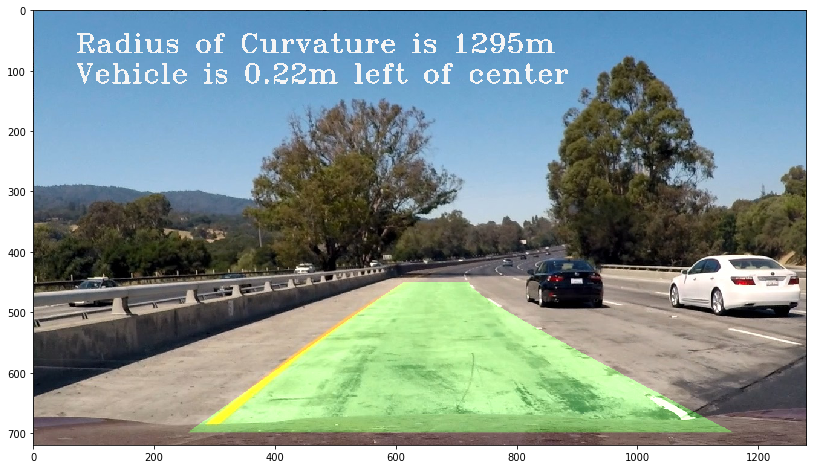

In [90]:
# View output image
i = 1
# #filename = f"./test_images/straight_lines{i}.jpg"
filename = f"./test_images/test{i}.jpg"
image = cv2.imread(filename)

cc = CalibrateCamera()
fl = FindLane(image, cc.mtx, cc.dist)
output = fl.output_image

output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (18, 8)) # View output images larger
plt.imshow(image_to_display)

In [92]:
# Save test images
import os
from PIL import Image

for name in os.listdir('test_images'):
    if not name == '.ipynb_checkpoints':
        input = mpimg.imread(f"test_images/{name}")
    
        fl = FindLane(input, cc.mtx, cc.dist)
        image = fl.output_image
        
        output = Image.fromarray(image)
        output.save(f"output_images/final_output_{name}")

In [89]:
# Save test videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

cc = CalibrateCamera()

def process_image(image):
    fl = FindLane(image, cc.mtx, cc.dist)
    return fl.output_image

output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
final = clip1.fl_image(process_image)

%time final.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [01:25<00:00,  5.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 40.8 s, sys: 1.1 s, total: 41.9 s
Wall time: 1min 28s
